This file contains the original ResNet18 trained on the flowers102 dataset. 

We froze the ResNet18 architecture, and we trained the network on the flowers102 dataset to learn the weights for the last layer of fully connected layer. 

We used this model's performance to show the difference between the frozen and unfrozen models. 

The required python packages will be installed by running the cell below this. 

The code is written such that it needs to be run on GPU. 

In [1]:
!pip install torch
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install pillow
!pip install scipy
!pip install torchvision
!pip install shutil
!pip install pylab

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement pylab (from vers

In [2]:
import pylab
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import scipy
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import time
from tempfile import TemporaryDirectory

Here, we are downloading the dataset and storing it into a `./train` folder. We applied the following transformations in the `data_transforms` dictionary. 

In [3]:
data_dir = './'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print(f"Downloading Training dataset:")
train_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='train', transform=data_transforms['train'], download=True)

print(f"Downloading Validation dataset:")
val_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='val', transform=data_transforms['val'])

print(f"Downloading Test dataset:")
test_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='test', transform=data_transforms['test'])

Here, we load the folders into dataloaders of `train`, `val`, `test`. The batch size is initialized as 4. 

In [4]:
datasets = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

# print(f"{len(train_dataset._labels)}")
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
# class_names = image_datasets['train'].classes

print(f"dataloaders: {dataloaders}")
print(f"Dataset sizes: {dataset_sizes}")


dataloaders: {'train': <torch.utils.data.dataloader.DataLoader object at 0x2aab9859eda0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x2aab9859fac0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x2aab9859f970>}
Dataset sizes: {'train': 1020, 'val': 1020, 'test': 6149}


In [5]:
print(f"dataloader train length: {len(dataloaders['train'].dataset)}")

dataloader train length: 1020


In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

The function below is to train the model. 

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    checkpoint_path = './model_checkpoints'
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    # Create a temporary directory to save training checkpoints
    # with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(checkpoint_path, 't_resnet18_original_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            # Calculating loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            print(f'{phase} Loss:\t{epoch_loss:.4f}\tAcc:\t{epoch_acc:.4f}')

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_loss, train_acc, val_loss, val_acc

Here, we load the ResNet18 model into the variable `model`. We then convert the last fully connected layer to an output of 102 neurons. 
We added a line to set `requires_grad = False` so that the model weights will be frozen. 
We load the model to the device. 

We used Cross Entropy Loss for the cost function, an SGD optimizer and a learning rate scheduler. However, the learning rate scheduler's step size is set at 200 to allow the model to learn as much as possible. 

In [8]:
model_path = './model_checkpoints/resnet18_original_params.pt'

check_file = os.path.exists(model_path)
if check_file:
    print(f"Loading model from checkpoint")
    model = torch.load(model_path)
else:
    print(f"Model checkpoint does not exist.\nDownloading new model...")
    model = models.resnet18(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=200, gamma=0.1)

Model checkpoint does not exist.
Device: cuda:0


Displaying the model architecture. 

In [9]:
for key, val in model.state_dict().items():
    if "mean" in key or "var" in key or "tracked" in key:
        continue
    print(f"{key} : {val.cpu().detach().numpy().shape}")

conv1.weight : (64, 3, 7, 7)
bn1.weight : (64,)
bn1.bias : (64,)
layer1.0.conv1.weight : (64, 64, 3, 3)
layer1.0.bn1.weight : (64,)
layer1.0.bn1.bias : (64,)
layer1.0.conv2.weight : (64, 64, 3, 3)
layer1.0.bn2.weight : (64,)
layer1.0.bn2.bias : (64,)
layer1.1.conv1.weight : (64, 64, 3, 3)
layer1.1.bn1.weight : (64,)
layer1.1.bn1.bias : (64,)
layer1.1.conv2.weight : (64, 64, 3, 3)
layer1.1.bn2.weight : (64,)
layer1.1.bn2.bias : (64,)
layer2.0.conv1.weight : (128, 64, 3, 3)
layer2.0.bn1.weight : (128,)
layer2.0.bn1.bias : (128,)
layer2.0.conv2.weight : (128, 128, 3, 3)
layer2.0.bn2.weight : (128,)
layer2.0.bn2.bias : (128,)
layer2.0.downsample.0.weight : (128, 64, 1, 1)
layer2.0.downsample.1.weight : (128,)
layer2.0.downsample.1.bias : (128,)
layer2.1.conv1.weight : (128, 128, 3, 3)
layer2.1.bn1.weight : (128,)
layer2.1.bn1.bias : (128,)
layer2.1.conv2.weight : (128, 128, 3, 3)
layer2.1.bn2.weight : (128,)
layer2.1.bn2.bias : (128,)
layer3.0.conv1.weight : (256, 128, 3, 3)
layer3.0.bn1.w

Model training starts here.

We used 100 epochs.

In [10]:
no_epochs = 100

model, train_loss, train_acc, val_loss, val_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=no_epochs)

Epoch 0/99
----------
train Loss:	4.7330	Acc:	0.0245
val Loss:	3.9891	Acc:	0.1039

Training complete in 0m 28s
Best val Acc: 0.103922
Epoch 1/99
----------
train Loss:	4.0946	Acc:	0.1049
val Loss:	3.1399	Acc:	0.3363

Training complete in 0m 43s
Best val Acc: 0.336275
Epoch 2/99
----------
train Loss:	3.5455	Acc:	0.2235
val Loss:	2.4770	Acc:	0.5294

Training complete in 0m 57s
Best val Acc: 0.529412
Epoch 3/99
----------
train Loss:	3.1460	Acc:	0.3490
val Loss:	2.1103	Acc:	0.5706

Training complete in 1m 10s
Best val Acc: 0.570588
Epoch 4/99
----------
train Loss:	2.7605	Acc:	0.4412
val Loss:	1.7198	Acc:	0.6686

Training complete in 1m 24s
Best val Acc: 0.668627
Epoch 5/99
----------
train Loss:	2.4533	Acc:	0.5108
val Loss:	1.5027	Acc:	0.6735

Training complete in 1m 38s
Best val Acc: 0.673529
Epoch 6/99
----------
train Loss:	2.2421	Acc:	0.5529
val Loss:	1.2975	Acc:	0.7186

Training complete in 1m 51s
Best val Acc: 0.718627
Epoch 7/99
----------
train Loss:	2.1046	Acc:	0.5882
val Loss:

In [11]:
torch.save(model, model_path)

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # Changed classes to labels so it corresponds to the labels from dataloader['val']
                ax.set_title(f'Predicted: {preds[j]} | True: {labels[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Here, we can see that the model got 5/6 predictions correct as a sample visualization. 

The model's best validation accuracy is at 83.6%. It is slightly lower than the ResNet18 model that had unfrozen parameters. 

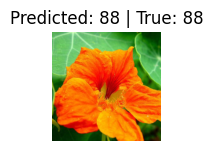

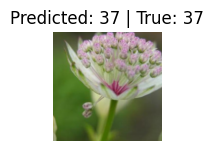

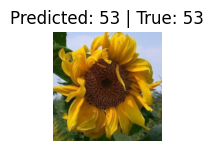

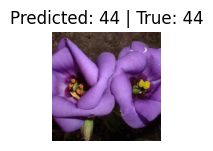

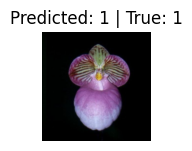

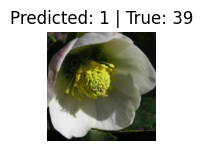

In [13]:
visualize_model(model)

In [14]:
def plot_graph(no_epoch, train, val, title):
    plt.figure()
    plt.plot(range(no_epoch), train, label='train')
    plt.plot(range(no_epoch), val, label='val')
    if "Accuracy" in title:
        plt.ylabel("Accuracy")
    elif "Loss" in title:
        plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

This is the plotting for epoch vs accuracy and epoch vs loss. 

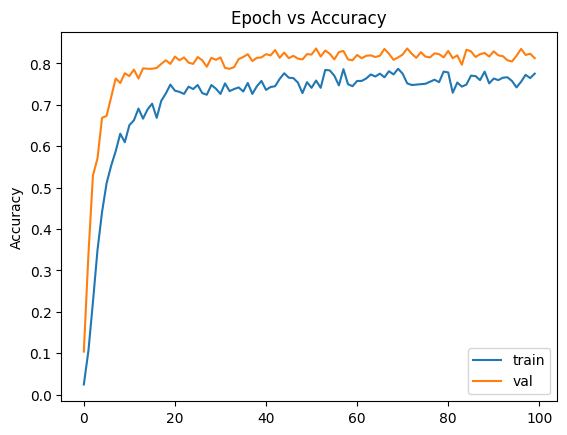

In [15]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i].cpu()

for i in range(len(val_acc)):
    val_acc[i] = val_acc[i].cpu()
    
plot_graph(no_epochs, train_acc, val_acc, "Epoch vs Accuracy")

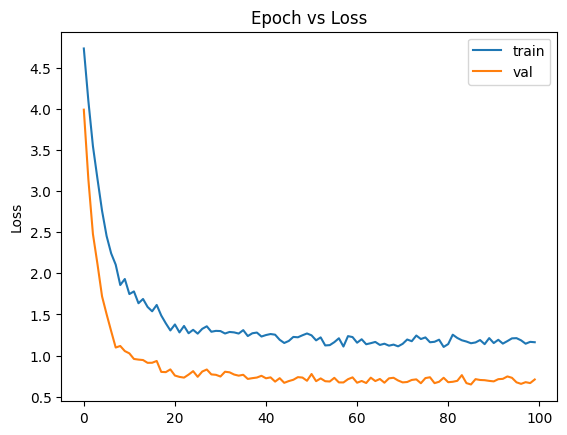

In [16]:
plot_graph(no_epochs, train_loss, val_loss, "Epoch vs Loss")

This is the function to test the model.

In [17]:
def test(model):
    was_training = model.training
    model.eval()
    # fig = plt.figure()
    size = len(dataloaders['test'].dataset)
    no_batches = len(dataloaders['test'])
    test_loss, correct = 0, 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
            if i % 20 == 0:
                print(f'Predicted: {preds[0]} | True: {labels[0]}')
                
    test_loss /= size
    correct = correct.double() / size
    model.train(mode=was_training)
    return test_loss, correct

In [18]:
test_loss, test_acc = test(model)
print(f'Test Loss:\t{test_loss:.4f}\tTest Acc:\t{test_acc:.4f}')


Predicted: 64 | True: 64
Predicted: 42 | True: 42
Predicted: 77 | True: 77
Predicted: 93 | True: 93
Predicted: 43 | True: 43
Predicted: 24 | True: 24
Predicted: 42 | True: 82
Predicted: 63 | True: 63
Predicted: 43 | True: 43
Predicted: 79 | True: 79
Predicted: 24 | True: 24
Predicted: 56 | True: 56
Predicted: 24 | True: 24
Predicted: 8 | True: 42
Predicted: 95 | True: 94
Predicted: 41 | True: 41
Predicted: 36 | True: 36
Predicted: 82 | True: 82
Predicted: 1 | True: 1
Predicted: 69 | True: 69
Predicted: 11 | True: 11
Predicted: 24 | True: 24
Predicted: 94 | True: 94
Predicted: 88 | True: 88
Predicted: 77 | True: 77
Predicted: 82 | True: 96
Predicted: 33 | True: 33
Predicted: 51 | True: 51
Predicted: 74 | True: 74
Predicted: 36 | True: 36
Predicted: 93 | True: 93
Predicted: 46 | True: 46
Predicted: 9 | True: 9
Predicted: 43 | True: 43
Predicted: 73 | True: 73
Predicted: 83 | True: 83
Predicted: 53 | True: 53
Predicted: 44 | True: 44
Predicted: 73 | True: 73
Predicted: 39 | True: 39
Predi

Here, we tested the model on the test dataset. The model had an accuracy of 80.13%.

Printing the model architecture here.

In [19]:
print(f"{model}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  